# Notebook 06: Classification - Predicting Sales for New Models

This notebook develops a classification model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE


# custom function imports
from custom_functions import *
from regression_custom_functions import *

In [7]:
# Import data
df_all_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

time_now = datetime.datetime.now()
df_models = df_all_models.dropna(subset=time_now.strftime(f"%Y-%m"))

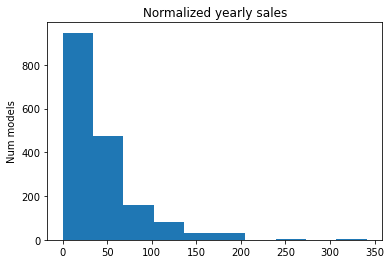

In [8]:
# Calculate a target value - Normalized Yearly Sales
df_models = calc_norm_yearly_sales(df_models, 4, 2019)

In [9]:
# Create new data frame with attributes from model to make predictions for new models in proposal
df_new_models = df_all_models[df_all_models[time_now.strftime(f"%Y-%m")].isna()]

## Label models by normalized yearly sales

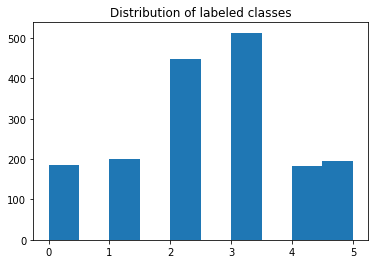

In [10]:
# Define upper bounds for normalized yearly sales to classify data
class_upper = {0:5,   # none
                   1:15,  # poor
                   2:30,  # fair
                   3:60, # average
                   4:90  # good
                  }       # excellent


# Use custom function and upper bounds to make classes
df_models['class'] = make_classes(df_models.norm_yearly_sales, class_upper)

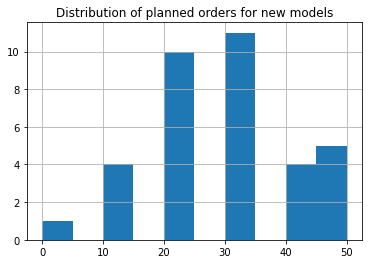

In [11]:
# compare to planned order for new models to check if same distribution
df_new_models.planned_order.hist()
plt.title('Distribution of planned orders for new models');

## Baseline Model

In [12]:
attributes = ['max_cart_qty','country_of_origin','warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'gender', 'color',
       'retail_price', 'collection', 'clasp_type', 'water_resistance',
       'movement_type']

X = df_models[attributes]

# Check no null values in X
df_models[df_models.isna()].sum().sum() #Should return 0

0.0

In [37]:
len(attributes)

15

In [39]:
len(X.collection.unique())

186

In [13]:
y = df_models['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
test_counts = y_test.value_counts()
test_counts

2    126
3    126
1     53
4     49
0     40
5     37
Name: class, dtype: int64

While the classes are imbalanced, I do not think this will significantly impact the model so I will not implement any techniques to create a balanced dataset

In [15]:
baseline = test_counts[0]/sum(test_counts)

print(f'Baseline accuracy is {round(baseline*100,1)}%.')

Baseline accuracy is 9.3%.


## Exploring different models

In [16]:
models = [('lr',LogisticRegressionCV(max_iter=10_000,l1)),('knn',KNeighborsClassifier(n_neighbors=3)),
          ('rf', RandomForestClassifier(n_estimators=500)), ('ab', AdaBoostClassifier(base_estimator=LogisticRegression(),algorithm='SAMME')),
          ('et', ExtraTreesClassifier(n_estimators=200))]

In [17]:
best_accuracy = baseline
df_preds = pd.DataFrame(y_test.values, columns=['y_test'])

LogisticRegressionCV(max_iter=10000)
Train accuracy: 0.6488785769528229
Test accuracy: 0.39443155452436196

KNeighborsClassifier(n_neighbors=3)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.6295436968290796
Test accuracy: 0.3225058004640371

RandomForestClassifier(n_estimators=500)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.9218870843000774
Test accuracy: 0.39443155452436196


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



AdaBoostClassifier(algorithm='SAMME', base_estimator=LogisticRegression())
Train accuracy: 0.48569218870843
Test accuracy: 0.3433874709976798

ExtraTreesClassifier(n_estimators=200)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.9218870843000774
Test accuracy: 0.38979118329466356

Best test accuracy: 0.39443155452436196
Best model: Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['max_cart_qty',
                                                   'country_of_origin',
                                                   'warranty', 'band_color',
                                                   'band_material',
                                                   'case_material',
                                                   'dial_color', 'case_size',
                                                   'gender', 

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [3, 5, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


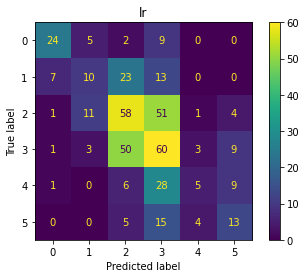

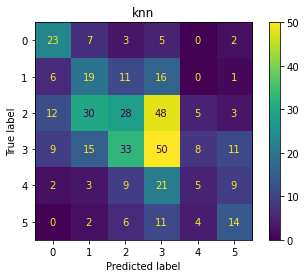

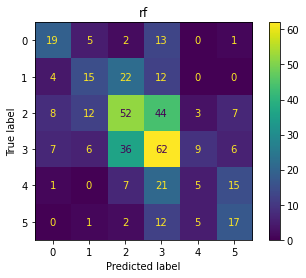

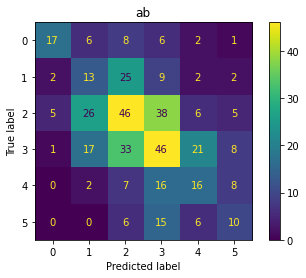

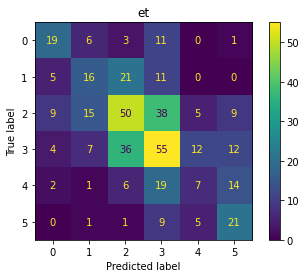

In [18]:
for model in models:
    pipe, preds, test_accuracy = create_evaluate_model_class(model, X_train, X_test, y_train, y_test)
    df_preds[f'preds_{model[0]}'] = preds
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = pipe
        
print('Best test accuracy:', best_accuracy)
print('Best model:', best_model)

## Production model

In [27]:
# Create new data frame with attributes from model to make predictions for new models in proposal
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_12054/2521488237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])


In [41]:
model = ('lr',LogisticRegressionCV(max_iter=10000,n_jobs = -1))

# Create a column transformer to one hot encode categorical variables
categorical_attributes = []
for attribute in X_train.columns:
    try:
        int(attribute)
    except:
        categorical_attributes.append(attribute)

ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                     categorical_attributes)],
                  remainder='passthrough',
                  verbose_feature_names_out=False)

# Create a pipeline to transform, scale, and model
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    model
])

# Fit model with training data
pipe.fit(X_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['max_cart_qty',
                                                   'country_of_origin',
                                                   'warranty', 'band_color',
                                                   'band_material',
                                                   'case_material',
                                                   'dial_color', 'case_size',
                                                   'gender', 'color',
                                                   'retail_price', 'collection',
                                 

In [42]:
# Create predictions with test data
preds = pipe.predict(test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0, 7, 11, 12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<AxesSubplot:>

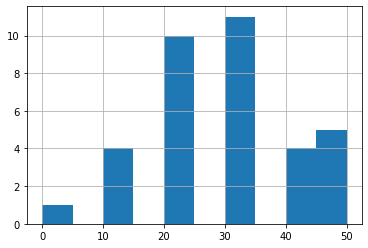

In [43]:
df_new_models.planned_order.hist()

(array([ 7.,  1., 10., 16.,  0.,  1.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <BarContainer object of 6 artists>)

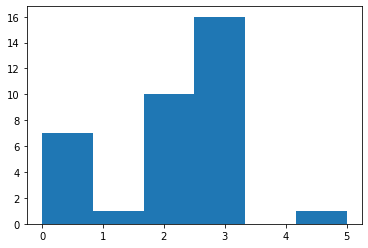

In [44]:
plt.hist(preds, bins=6)

<AxesSubplot:>

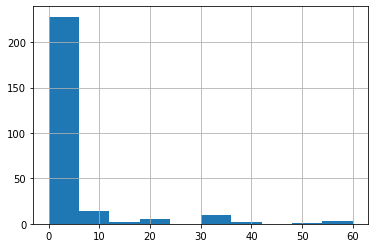

In [45]:
df_models.planned_order.hist()

In [24]:
preds

array([0, 0, 0, 2, 2, 2, 2, 0, 2, 5, 3, 3, 3, 3, 2, 0, 3, 5, 0, 1, 3, 2,
       3, 0, 2, 2, 2, 2, 2, 0, 3, 5, 3, 3, 1])

In [47]:
# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions[f'monthly_classifications_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds

new_model_predictions.to_csv('../data/predictions/new_models_classifications.csv',index=False)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_12054/449321751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_predictions[f'monthly_classifications_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds
